In [1]:
# import modules
import numpy as np
import librosa
import music_gen_lib as mgl
from keras.utils import np_utils
import time
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf
import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("white")

Using TensorFlow backend.


In [2]:
random_seed = 0

In [3]:
data_converted = True
if data_converted == False:
    # load all the data
    X, SR, T = mgl.load_original_data()
    # data format:
    #       x: 1d numpy array
    #       t: 1d numpy array with numsic genre names (numeric arrays or multinomial vector?)

    # convert the data into mel-scale spectrogram
    st = time.time()
    newX = mgl.batch_mel_spectrogram(X, SR)
    print(time.time() - st)

    # save the data into npz
    np.savez_compressed("audio_sr_label.npz", X=newX, SR=SR, T=T)

else:
    st = time.time()
    data = np.load("audio_sr_label.npz")
    X = data["X"]
    SR = data["SR"]
    T = data["T"]
    loading_time = time.time() - st
    print("Loading takes %f seconds." % (loading_time))


# Use log transformation to preserve the order but shrink the range
X = np.log(X + 1)
X = X[:, :, :, np.newaxis]  # image channel should be the last dimension, check by using print K.image_data_format()


# convert string type labels to vectors
genres = np.unique(T)
genres_dict = dict([[label, value] for value, label in enumerate(genres)])
T_numeric = np.asarray([genres_dict[label] for label in T])
T_vectorized = np_utils.to_categorical(T_numeric)

Loading takes 14.932948 seconds.


In [4]:
idxes_list = np.load("shuffled_idx_list.npz")
training_idxes = idxes_list["training_idxes_list"][random_seed]
validation_idxes = idxes_list["validation_idxes_list"][random_seed]
testing_idxes = idxes_list["testing_idxes_list"][random_seed]

training_X = X[training_idxes]
validation_X = X[validation_idxes]
testing_X = X[testing_idxes]

training_T = T_vectorized[training_idxes]
validation_T = T_vectorized[validation_idxes]
testing_T = T_vectorized[testing_idxes]
# testing_T_label = T[testing_idxes]

In [21]:
# helper function
def plot_confusion_matrix(cm):
    numeric_label = np.asarray(genres_dict.values())
    str_label = genres_dict.keys()
    sort_idx = np.argsort(numeric_label)
    alpha = [str_label[idx] for idx in sort_idx]
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap="jet")
    fig.colorbar(cax)
    plt.xticks(np.arange(10), alpha, rotation=30)
    plt.yticks(np.arange(10), alpha)
    # ax.set_xticklabels(['']+alpha)
    # ax.set_yticklabels(['']+alpha)
    plt.xlabel("prediction"); ax.xaxis.set_label_position('top')
    plt.ylabel("expected")
    plt.tight_layout()
    
def naive_augment_data(testing_X, testing_T):
    augmented_representation = []
    augmented_T = []
    for iii in xrange(len(testing_X)):
        song_mel_spectrogram = testing_X[iii].squeeze()
        sms_label = testing_T[iii]
        segment_list = segment_song_melspectrogram(song_mel_spectrogram, overlap=0.5)

        for lhs in segment_list:
            augmented_representation.append(lhs.flatten(order="C"))
            augmented_T.append(sms_label)
    augmented_representation = np.asarray(augmented_representation)
    augmented_T = np.asarray(augmented_T)
    return(augmented_representation, augmented_T)

def segment_song_melspectrogram(song_mel_spectrogram, num_fft_windows=mgl.num_fft_windows, overlap=0.5):
    largest_idx = song_mel_spectrogram.shape[1] - num_fft_windows - 1
    step_size = int((1 - overlap) * num_fft_windows)
    num_segments = int(largest_idx / step_size)
    segment_edges = np.arange(num_segments) * step_size
    segment_list = []
    for idx in segment_edges:
        segment = song_mel_spectrogram[:, idx : idx + num_fft_windows]
        segment_list.append(segment)
    return np.asarray(segment_list)

def plot_labelled_scatters(X1, X2, labels, figsize=(14, 10)):
    import matplotlib as mpl
    num_classes = len(genres_dict)
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0, num_classes, num_classes+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots(1,1, figsize=figsize)
    scat = ax.scatter(X1, X2, c=labels, cmap=cmap, norm=norm)
    # create the colorbar
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Custom cbar')
    ax.set_title('Discrete color mappings')
    
def scatter_3d(locs, labels, zlim=None):
    import matplotlib as mpl
    from mpl_toolkits.mplot3d import Axes3D
    num_classes = 10
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0, num_classes, num_classes+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if zlim is not None:
        ax.set_zlim(zlim[0], zlim[1])
    ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2], c=labels, cmap=cmap)

In [6]:
raw_augmented_training_X, raw_augmented_training_T = naive_augment_data(training_X, training_T)

In [7]:
raw_augmented_testing_X, raw_augmented_testing_T = naive_augment_data(testing_X, testing_T)

In [32]:
### LDA/PCA from raw data
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

kept_dimension = 1000

In [38]:
raw_pca = decomposition.PCA(n_components=kept_dimension)
raw_pca.fit(raw_augmented_training_X)
raw_training_PCs = raw_pca.transform(raw_augmented_training_X)
raw_testing_PCs = raw_pca.transform(raw_augmented_testing_X)

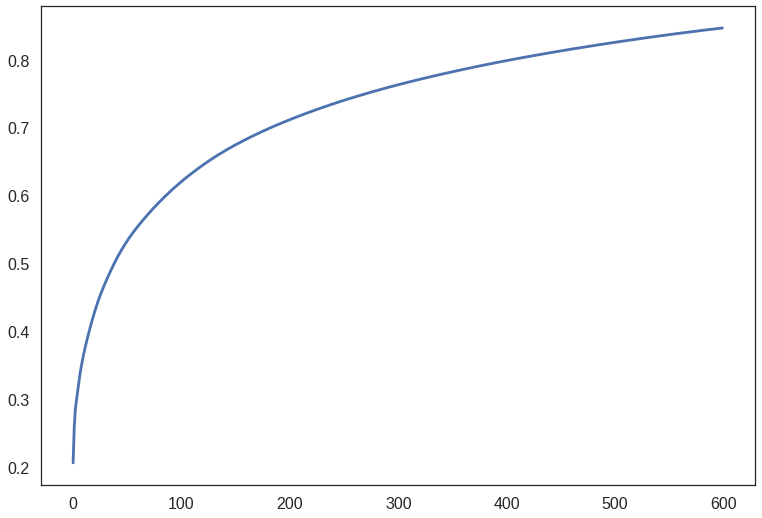

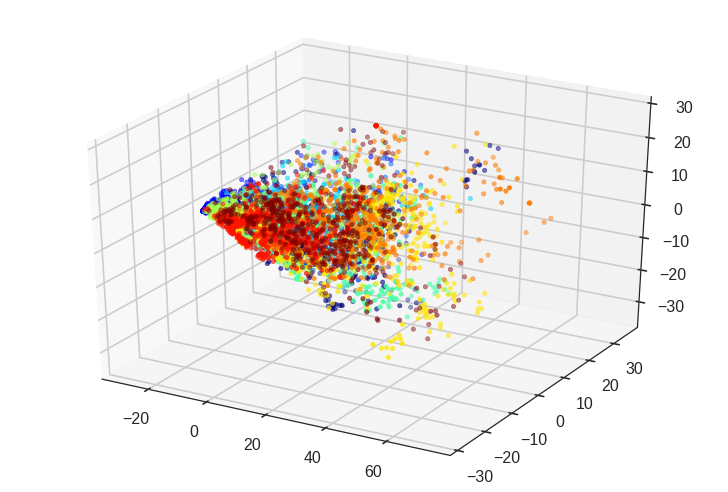

In [44]:
plt.figure()
plt.plot(np.cumsum(raw_pca.explained_variance_ratio_));
scatter_3d(raw_testing_PCs[:, :3], np.argmax(raw_augmented_testing_T, axis=1))

In [40]:
raw_lda = LinearDiscriminantAnalysis(n_components=kept_dimension)
raw_lda.fit(raw_training_PCs, np.argmax(raw_augmented_training_T, axis=1))
raw_testing_lda_loadings = raw_lda.transform(raw_testing_PCs)

In [41]:
print np.argmax(raw_augmented_training_T, axis=1).shape
raw_testing_lda_loadings[:, :3].shape

(9000,)


(5400, 3)

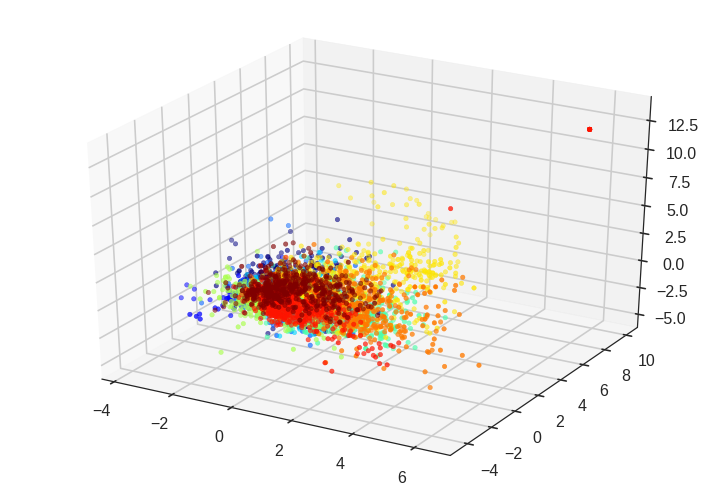

In [45]:
scatter_3d(raw_testing_lda_loadings[:, :3], np.argmax(raw_augmented_testing_T, axis=1))
plt.savefig("raw_pc2ldas.png", dpi=600)